In [130]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
% matplotlib inline
import nltk
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid',font="calibri")
#sns.set(style="white)



dir = 'C:\\Users\\Travis Park\\Google Drive\\UN\\Team MOZART RAP\\'

In [83]:
'''To-Do
    -Include keyword synonyms in TF-IDF
    -Should we stem the targets and input text?
    -POS and structure
    -The paragraphs need to be rolled up by Policy Area/Sector
'''

'To-Do\n    -Include keyword synonyms in TF-IDF\n    -Should we stem the targets and input text?\n    -POS and structure\n    -The paragraphs need to be rolled up by Policy Area/Sector\n'

In [3]:
SDG_Targets = pd.read_excel(dir +'SDG.xlsx', names = ['ID', 'Target'],sheetname = 'Sheet1')

In [4]:
#writes country SDG report to list 'f' split by paragraph
f = open(dir + 'Bhutan_doc_test.txt', 'r')
f = f.read().replace('. \n\n','.\n\n').split('.\n\n')
f = [w.replace('\n',' ') for w in f]
for w in f:
    if len(w) <= 100:
        f.remove(w)

In [5]:
len(f)

1049

In [6]:
input_text = f

In [7]:
vectorizer =TfidfVectorizer(stop_words='english', min_df=1,lowercase = True) 

d_columns = ['Paragraph','Text','Target','Target_Text','CosineSimilarity']

d = pd.DataFrame(columns = d_columns)

def match_to_target(inputlist,paragraphnumber):   
    #runs tfidf vectorizer with paragraph against all targets, returns the target with highest cosine similarity
    global d    
    add_paragraph(inputlist,paragraphnumber)
    x = vectorizer.fit_transform(inputlist)
    y = pd.DataFrame((x * x.T).A)
    z = len(inputlist)-1
    y1 = max(y[(y[z] < 0.999999)][z])
    y_value = y[z].loc[y[z] == y1].index.tolist()
    y_value = y_value[0]   
    
    indx = SDG_Targets.loc[SDG_Targets['Target']==inputlist[y_value]]['ID'].tolist()
    indx = indx[0]
    indx_text = SDG_Targets.loc[SDG_Targets['ID']==indx]['Target'].tolist()
    indx_text = indx_text[0]
    
    d1 = pd.DataFrame([[paragraphnumber,inputlist[len(inputlist)-1],indx, indx_text, y1]], columns = d_columns)
    d =pd.concat([d,d1])
    
targets = []

def process_targets(df_targets):
    #appends all targets in file to a dataframe

    targets.clear()
    b = 0
    while b < len(df_targets):
        targets.append(df_targets['Target'][b])
        b=b+1

flag=0

def add_paragraph(inputlist,paragraphnumber):
    #adds one paragraph to list of targets
    global flag
    if flag == 1:#if a paragraph has already been appended, replace it with a new one
        inputlist[len(inputlist)-1] = input_text[paragraphnumber]
    elif flag == 0:#if no paragraph has been appended, add a new one
        targets.append(input_text[0])
        flag = 1

In [8]:
process_targets(SDG_Targets)

In [9]:
i=0
while i < len(input_text):
    match_to_target(targets,i)
    i=i+1

In [10]:
d.head()

,Paragraph,Text,Target,Target_Text,CosineSimilarity
0,0.0,Eleventh Five Year Plan - Main Document Volume...,8.1,Sustain per capita economic growth in accorda...,0.079055
0,1.0,ISBN 978-99936-55-01-5 Eleventh Five Year ...,8.1,Sustain per capita economic growth in accorda...,0.097158
0,2.0,The government has provided education to our y...,8.6,"By 2020, substantially reduce the proportion ...",0.232484
0,3.0,The recent Rupee shortage is a serious proble...,11.4,Strengthen efforts to protect and safeguard t...,0.114321
0,4.0,- His Majesty The King’s address to the nat...,14.3,Minimize and address the impacts of ocean aci...,0.065184


In [11]:
d.to_csv(dir + 'TFIDF.csv')

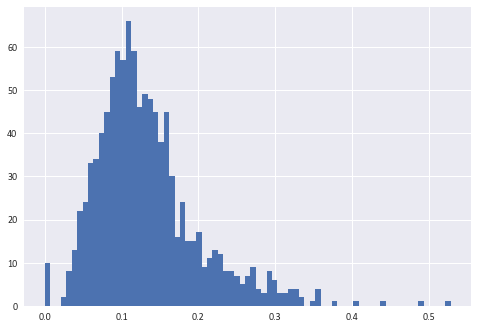

In [131]:
d['CosineSimilarity'].hist(bins = 75)

In [132]:
e = d[(d.Target == 10.1)]

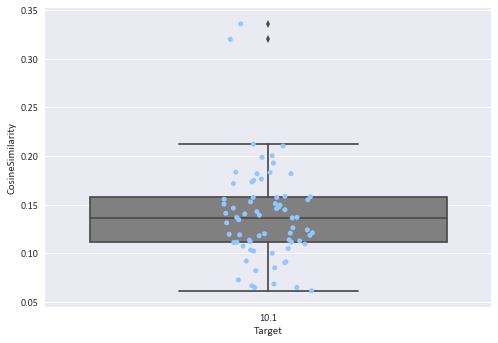

In [133]:
c = sns.boxplot(x="Target", y="CosineSimilarity", data=e, color = 'grey')
c = sns.stripplot(x="Target", y="CosineSimilarity", data=e, jitter=True, edgecolor="gray",palette="pastel")

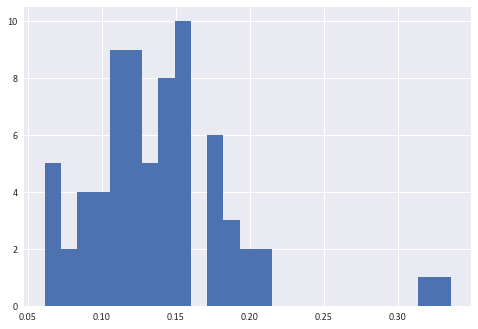

In [134]:
e['CosineSimilarity'].hist(bins = 25)

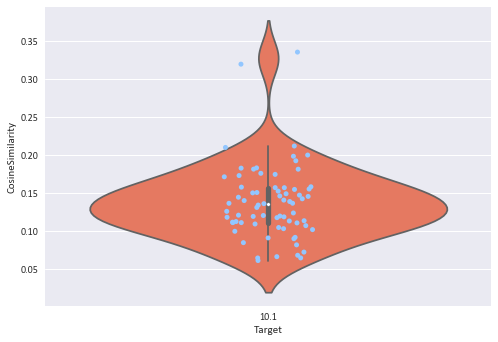

In [135]:
sns.violinplot(x="Target", y="CosineSimilarity", data=e, size=5,palette="Reds_r")
sns.stripplot(x="Target", y="CosineSimilarity", data=e, jitter=True, edgecolor="gray", palette="pastel")

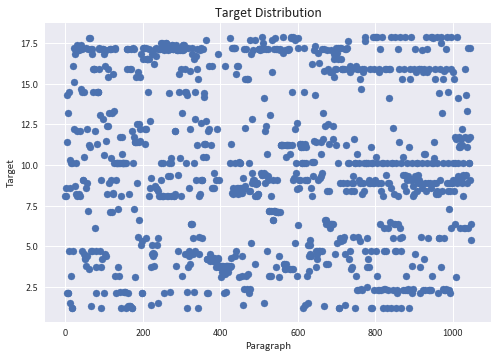

In [136]:
plt.scatter(x = d['Paragraph'], y = d['Target'])
plt.xlabel('Paragraph', fontsize=11)
plt.ylabel('Target', fontsize=11)
plt.title('Target Distribution', fontsize=14)